In [36]:
# Update following paths (including the one in load_data) to your local paths
# Synch your data with the remote server
# Update the csv file whit all information on runs

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit
import plotly.express as px
import statsmodels.api as sm
import numpy as np
from scipy.optimize import curve_fit
import os
from IPython.display import display, HTML
import re
from docx import Document
from docx.shared import Inches
from docx.shared import RGBColor
from io import BytesIO
dir_path = r"C:\Users\louis\OneDrive\Bureau\Stage Tokyo\data_Spring8\runs900410to902083"
folder = r"C:\Users\louis\OneDrive\Bureau\Stage Tokyo\data_Spring8"
folder_path_runs = 'C:/Users/louis/OneDrive/Bureau/Stage Tokyo/data_Spring8/docs_runs/'

In [37]:
def load_current_Scan(runstart, runend):
    df0 = pd.read_csv(dir_path+'/run'+str(runstart)+'.csv')
    SXMOKE_On = []
    SXMOKE_Off = []
    SXFUN_On = []
    SXFUN_Off = []
    for ii in range(runstart, runend + 1):
        df0 = pd.read_csv(f'/Users/louis/OneDrive/Bureau/Stage Tokyo/data_Spring8/runs900410to902083/run{ii}.csv')
    # 清理列名前后的空格
        df0.columns = df0.columns.str.strip()
        df0['On'] = df0['On'].fillna(0)
        for kk in range(len(df0)):
            I_raw = df0['I_raw'].iloc[kk]
            I_norm = df0['I_norm'].iloc[kk]
            I0_GM2 = df0['I0(GM2)'].iloc[kk]
            On_val = df0['On'].iloc[kk]
            if -1 < I_raw < 0.4 and I0_GM2 > -1:
                if On_val > 0.1:
                    df_MOKE_Off = I_raw
                    df_fun_Off = I0_GM2
                    SXMOKE_Off.append(df_MOKE_Off)
                    SXFUN_Off.append(df_fun_Off)
                elif On_val <= 0.1:
                    df_MOKE_On = I_raw
                    df_fun_On = I0_GM2
                    SXMOKE_On.append(df_MOKE_On)
                    SXFUN_On.append(df_fun_On)
    return np.array(SXMOKE_On), np.array(SXMOKE_Off), np.array(SXFUN_On),np.array(SXFUN_Off)   


In [ ]:
# Analyzing the difference between On and Off scans
eV = 73 # photon energy
print_parameters = True # Can be disabled if not relevant (runs from multiple scans)
run_id_first = 905718 # first run for this eV
run_id_last = 905750 # last run for this eV
if run_id_first > run_id_last:
    raise ValueError("run_id_first should be lower than run_id_last")
output_path = folder+'\docs_analysis\Analysis_'+str(eV)+'eV.docx'
if os.path.exists(output_path):
    raise FileExistsError(f"{output_path} already exists. Execution stopped.")
## Open google sheet
df = pd.read_csv(folder+'\\202505_orbital_MOKE - 工作表1.csv')
mask = df[df.columns[0]].astype(str).str.startswith('Current measurement#')
df_current_measurements = df[mask]
start_run_arr = df_current_measurements['start run#'].values.tolist()
end_run_arr = df_current_measurements['end run#'].values.tolist()
print("Creating the docx file for analysis of runs at {} eV".format(eV))
# Don't forget to change these parameters
Resistance_value = 160
AT1 = 'Zr 0.5 um'
AT2 = 'Zr 0.15 um'
AT1b = ''
AT2b = 'Zr 1.0 um'
AT3b = ''
AT4b = ''
run_id_list = np.arange(run_id_first, run_id_last+1).tolist()
run_id_list_real = [x for x in run_id_list if x in start_run_arr and x in end_run_arr]
Current_list = []
I_on_list = []
I_off_list = []
I_list = []
for run_id in run_id_list_real:
    print('Using run : ', run_id)
    scan_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_id, 'Scan'].values
    photon_energy_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_id, 'Photon Energy'].values
    run_value = run_id
    current_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_id, 'Current (mA)'].values
    Gain_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_id, 'Gain settting'].values
    MCP_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_id, 'MCP Voltage'].values
    if photon_energy_value != str(eV)+'eV':
        print("Photon energy of this run is not {eV} eV. Skipping this run.")
        continue
    SXMOKE_On, SXMOKE_Off, SXFUN_On, SXFUN_Off = load_current_Scan(run_id, run_id)
    On_x = np.linspace(0, 500, len(SXMOKE_On))
    Off_x = np.linspace(0, 500, len(SXMOKE_Off))
    # Remove NaN/inf
    mask_on = np.isfinite(SXFUN_On) & np.isfinite(SXMOKE_On)
    mask_off = np.isfinite(SXFUN_Off) & np.isfinite(SXMOKE_Off)
    y_on = SXMOKE_On[mask_on]
    y_off = SXMOKE_Off[mask_off]
    avg_y_on = np.mean(y_on)
    avg_y_off = np.mean(y_off)
    current_value_float = float(current_value[0].replace('mA', ''))
    I_on_list.append(avg_y_on)
    I_off_list.append(avg_y_off)
    if avg_y_off != 0:
        Current_list.append(current_value_float)
        I_list_value = (avg_y_on - avg_y_off) / avg_y_off
        I_list.append(I_list_value)
    else:
        print("Error: I_off is zero, cannot divide by zero.")
doc = Document()
doc.add_heading('Report on MOKE Analysis', level=1)
paragraph = doc.add_paragraph() 
if print_parameters:
    run = paragraph.add_run("Event Per Step: 10000")
    run.add_break()
    run.add_text("Scan Mode: sync")
    run.add_break()
    run.add_text("Retry Mode: restart")
    run.add_break()
    run.add_text("Scan Config File:##")
    run.add_break()
    run.add_text("Pulse Selector Setting: XFEL(Continuous; 60 Hz)")
    run.add_break()
    run3 = paragraph.add_run("in EH4a")
    run3.add_break()
    run3.add_text("photon energy : "+str(photon_energy_value[0]))
    run3.add_break()
    run3.add_text("AT1: "+AT1)
    run3.add_break()
    run3.add_text("AT2: "+AT2)
    run3.add_break()
    run3.add_text("in OH")
    run3.add_break()
    run3.add_text("AT1: "+AT1b)
    run3.add_break()
    run3.add_text("AT2: "+AT2b)
    run3.add_break()
    run3.add_text("AT3: "+AT3b)
    run3.add_break()
    run3.add_text("AT4: "+AT4b)
    run3.add_break()
    run3.add_text("Gain : "+str(Gain_value[0]))
    run3.add_break()
    run3.add_text("MCP : "+str(MCP_value[0]))
    run3.add_break()
run2 = paragraph.add_run("Resistance: {} Om".format(Resistance_value))
run2.add_break()
# fit graph
slope, intercept, *_ = linregress(Current_list, I_list)
I_fit = [slope * x + intercept for x in Current_list]
run2.add_text("Slope: {:.9f}".format(slope))
run2.add_break()
run2.add_text("Intercept: {:.9f}".format(intercept))
run2.add_break()
run2.font.color.rgb = RGBColor(255, 0, 0)
buf = BytesIO()
plt.scatter(Current_list, I_list, color='blue',marker='s', s=50)
plt.plot(Current_list, I_fit, color='red')
plt.title('Intensity Difference vs Current for {} eV'.format(eV))
plt.xlabel('Current (mA)')
plt.ylabel('(I_on-I_off)/I_off')
plt.grid()
plt.savefig(buf, format='png')
plt.close()
doc.add_picture(buf, width=Inches(4))
doc.save(output_path)
print("Docx file created successfully for analysis of runs at {} eV".format(eV))


Creating the docx file for analysis of runs at 74 eV
Using run :  905685
Using run :  905686
Using run :  905687
Using run :  905688
Using run :  905689
Using run :  905690
Using run :  905691
Using run :  905692
Using run :  905693
Using run :  905694
Using run :  905695
Using run :  905696
Using run :  905697
Using run :  905698
Using run :  905699
Using run :  905700
Using run :  905701
Using run :  905702
Using run :  905703
Using run :  905704
Using run :  905705
Using run :  905706
Using run :  905707
Using run :  905708
Using run :  905709
Using run :  905710
Using run :  905711
Using run :  905712
Using run :  905713
Using run :  905714
Using run :  905715
Using run :  905716
Using run :  905717
Docx file created successfully for analysis of runs at 74 eV


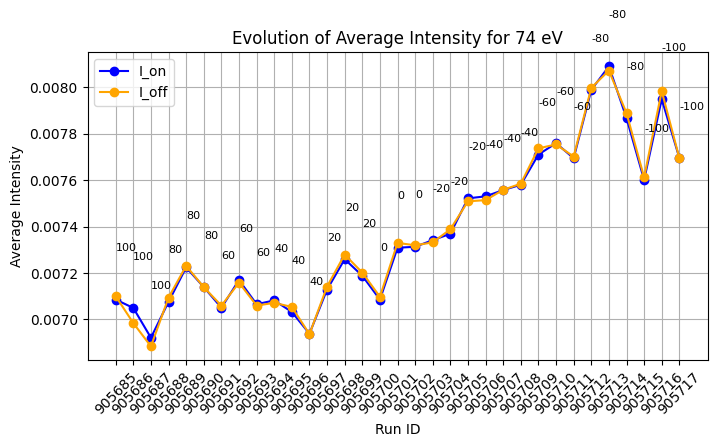

In [39]:
# Analyzing evolution of average intensity
plt.figure(figsize=(8, 4))
plt.plot(run_id_list_real, I_on_list, label='I_on', marker='o', color='blue')
plt.plot(run_id_list_real, I_off_list, label='I_off', marker='o', color='orange')
plt.xlabel('Run ID')
plt.xticks(run_id_list_real, rotation=45)
plt.ylabel('Average Intensity')
plt.title('Evolution of Average Intensity for {} eV'.format(eV))
plt.legend()
plt.grid()
for x, y, current in zip(run_id_list_real, I_on_list, Current_list):
    plt.text(x, y+0.0002, f'{current:.0f}', fontsize=8, ha='left', va='bottom', color='black')

plt.show()